#data load

In [0]:
from keras.datasets import fashion_mnist, cifar10
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import cv2
import keras

class data:
    def __init__(self, data_size):
        self.data_size = data_size

    def resize(self, x, to_color=True):
        result = []

        for i in range(len(x)):
            if to_color:
                img = cv2.cvtColor(x[i], cv2.COLOR_GRAY2RGB)
                img = cv2.resize(img,dsize=(96,96))
            else:
                img = cv2.resize(x[i],dsize=(96,96))
            result.append(img)

        return np.array(result)

    def choose_data(self, x, y, normal_id, anomaly_id):
        x_normal, x_anomaly = [], []
        x_ref, y_ref = [], []

        for i in range(len(x)):
            if y[i] == normal_id:# スニーカーは7#鹿は4
                x_normal.append(x[i].reshape((x.shape[1:])))
            elif y[i] == anomaly_id:# ブーツは9#馬は7
                x_anomaly.append(x[i].reshape(x.shape[1:]))
            else:
                x_ref.append(x[i].reshape((x.shape[1:])))
                y_ref.append(y[i])

        return np.array(x_normal), np.array(x_anomaly), np.array(x_ref), y_ref

    def random_choose(self, x, y, size):
        number = np.random.choice(np.arange(0, len(x)), size, replace=False)
        return_x, return_y = [], []

        if len(y) > 0:
            for i in number:
                return_x.append(x[i].reshape((x.shape[1:])))
                return_y.append(y[i])
            return np.array(return_x), return_y
        else:
            for i in number:
                return_x.append(x[i].reshape((x.shape[1:])))
            return np.array(return_x)

    def get_fashion_data(self):
        # dataset
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

        x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
        x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

        x_train = x_train.astype('float32') / 255
        x_test = x_test.astype('float32') / 255

        x_train_normal, _, x_ref, y_ref = self.choose_data(x_train, y_train, 7, 9)

        #train_normalデータからランダムに抽出
        x_train_normal = self.random_choose(x = x_train_normal, y=[], size = int(self.data_size/8))

        #refデータからランダムに抽出
        x_ref, y_ref = self.random_choose(x = x_ref, y = y_ref, size = self.data_size)
        y_ref = to_categorical(y_ref)

        # テストデータ
        x_test_normal, x_test_anomaly, _, _ = self.choose_data(x_test, y_test, 7, 9)

        x_train_normal = self.resize(x_train_normal)
        x_ref = self.resize(x_ref)
        x_test_normal = self.resize(x_test_normal)
        x_test_anomaly = self.resize(x_test_anomaly)

        #print(x_train_normal.shape)
        #print(x_ref.shape)
        #print(y_ref.shape)
        #print(x_test_normal.shape)
        #print(x_test_anomaly.shape)

        return x_train_normal, x_ref, y_ref, x_test_normal, x_test_anomaly

    def get_cifar_data(self):
        # dataset
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()

        x_train = x_train.astype('float32') / 255
        x_test = x_test.astype('float32') / 255
        
        x_train_normal, _, x_ref, y_ref = self.choose_data(x_train, y_train, 4, 7)

        #train_normalデータからランダムに抽出
        x_train_normal = self.random_choose(x = x_train_normal, y=[], size = int(self.data_size/8))

        #refデータからランダムに抽出
        x_ref, y_ref = self.random_choose(x = x_ref, y = y_ref, size = self.data_size)
        y_ref = to_categorical(y_ref)

        # テストデータ
        x_test_normal, x_test_anomaly, _, _ = self.choose_data(x_test, y_test, 4, 7)

        x_train_normal = self.resize(x_train_normal, False)
        x_ref = self.resize(x_ref, False)
        x_test_normal = self.resize(x_test_normal, False)
        x_test_anomaly = self.resize(x_test_anomaly, False)

        #print(x_train_normal.shape)
        #print(x_ref.shape)
        #print(y_ref.shape)
        #print(x_test_normal.shape)
        #print(x_test_anomaly.shape)

        return x_train_normal, x_ref, y_ref, x_test_normal, x_test_anomaly

In [0]:
def get_auc(Z1, Z2):
    y_true = np.zeros(len(Z1)+len(Z2))
    y_true[len(Z1):] = 1#0:正常、1：異常

    # FPR, TPR(, しきい値) を算出
    fpr, tpr, _ = metrics.roc_curve(y_true, np.hstack((Z1, Z2)))

    # AUC
    auc = metrics.auc(fpr, tpr)

    return fpr, tpr, auc

def auc(Z1, Z2):
    fpr_arc, tpr_arc, auc = get_auc(Z1, Z2)
    
    # ROC曲線をプロット
    plt.plot(fpr_arc, tpr_arc, label='AdaCos(AUC = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

    return auc

#AdaCos

In [0]:
from keras import backend as K
from keras.engine.topology import Layer
import tensorflow as tf
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Activation
from keras.models import Model
from keras.optimizers import Adam
from sklearn import metrics

# adacosの層
class Adacoslayer(Layer):
    # s:softmaxの温度パラメータ, m:margin
    def __init__(self, output_dim, s=30, m=0.50, easy_margin=False):
        self.output_dim = output_dim
        self.s = s
        self.m = m
        self.easy_margin = easy_margin
        super(Adacoslayer, self).__init__()

    # 重みの作成
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[0][1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(Adacoslayer, self).build(input_shape)


    # mainの処理 
    def call(self, x):
        y = x[1]
        x_normalize = tf.math.l2_normalize(x[0]) # x = x'/ ||x'||2
        k_normalize = tf.math.l2_normalize(self.kernel) # Wj = Wj' / ||Wj'||2

        cos_m = K.cos(self.m)
        sin_m = K.sin(self.m)
        th = K.cos(np.pi - self.m)
        mm = K.sin(np.pi - self.m) * self.m

        cosine = K.dot(x_normalize, k_normalize) # W.Txの内積
        sine = K.sqrt(1.0 - K.square(cosine))

        phi = cosine * cos_m - sine * sin_m #cos(θ+m)の加法定理

        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine) 

        else:
            phi = tf.where(cosine > th, phi, cosine - mm) 

        # 正解クラス:cos(θ+m) 他のクラス:cosθ 
        output = (y * phi) + ((1.0 - y) * cosine) 
        output *= self.s

        return output

    def compute_output_shape(self, input_shape):

        return (input_shape[0][0], self.output_dim) #入力[x,y]のためx[0]はinput_shape[0][0]

# adacosとmobilenetV2を接合して学習
def train_adacos(x, y, classes):
    print("Adacos training...")
    base_model=MobileNetV2(input_shape=x.shape[1:],alpha=0.5,
                           weights='imagenet',
                           include_top=False)


    #add new layers 
    c = base_model.output
    yinput = Input(shape=(classes,)) #Adacosで使用
    # stock hidden model
    hidden = GlobalAveragePooling2D()(c) 
    c = Adacoslayer(classes, np.sqrt(2)*np.log(classes-1), 0.0)([hidden,yinput]) #outputをクラス数と同じ数に
    prediction = Activation('softmax')(c)
    model = Model(inputs=[base_model.input, yinput], outputs=prediction)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001, amsgrad=True),
                  metrics=['accuracy'])

    #学習
    hist = model.fit([x, y], y, batch_size=128, epochs=10, verbose = False)

    #plt.figure()               
    #plt.plot(hist.history['acc'],label="train_acc")
    #plt.legend(loc="lower right")
    #plt.show()

    return model

def get_score_arc(model, train, test):
    """
    テスト用
    model: 特徴抽出用モデル(predict)
    """
    model = Model(model.get_layer(index=0).input, model.get_layer(index=-4).output) # Adacosを削除
    
    # 正常vectorの呼び出し
    hold_vector = model.predict(train)# shape(len(train), 1280)

    # test_vectorの呼び出し
    predict_vector = model.predict(test)# shape(len(test), 1280)

    score = []

    for i in range(len(predict_vector)):
        cos_similarity = cosine_similarity(predict_vector[i], hold_vector) # shape(len(test), len(train))
        score.append(np.max(cos_similarity))

    return np.array(score)

# コサイン類似度の計算
def cosine_similarity(x1, x2): 
    if x1.ndim == 1:
        x1 = x1[np.newaxis]
    if x2.ndim == 1:
        x2 = x2[np.newaxis]
    x1_norm = np.linalg.norm(x1, axis=1)
    x2_norm = np.linalg.norm(x2, axis=1)
    cosine_sim = np.dot(x1, x2.T)/(x1_norm*x2_norm+1e-10)
    return cosine_sim

#Experiment(fashion-MNIST)

1 /10
4423680/4422102 [==============================] - 1s 0us/step
Adacos training...











3203072/3201480 [==============================] - 1s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






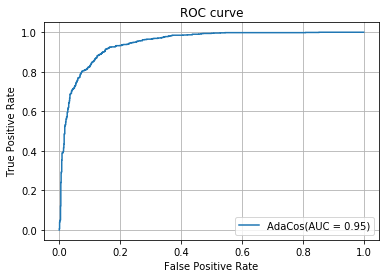

2 /10
Adacos training...


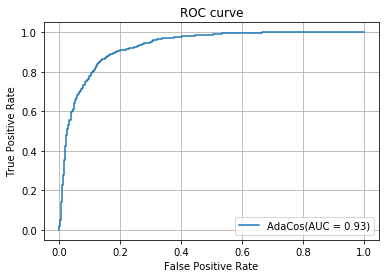

3 /10
Adacos training...


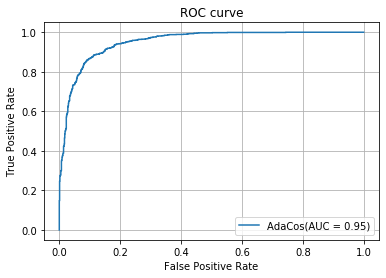

4 /10
Adacos training...


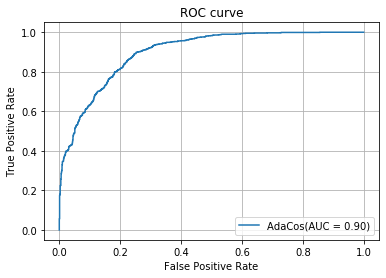

5 /10
Adacos training...


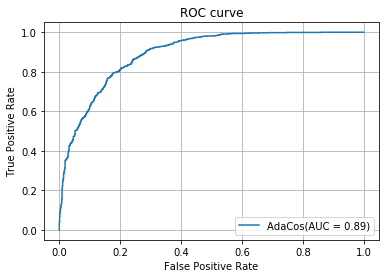

6 /10
Adacos training...


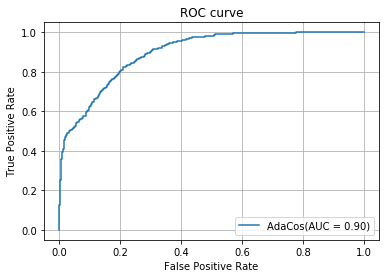

7 /10
Adacos training...


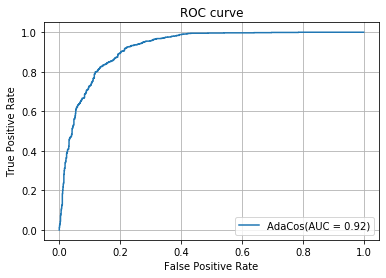

8 /10
Adacos training...


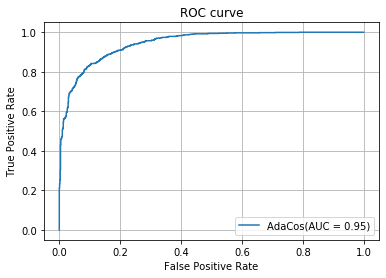

9 /10
Adacos training...


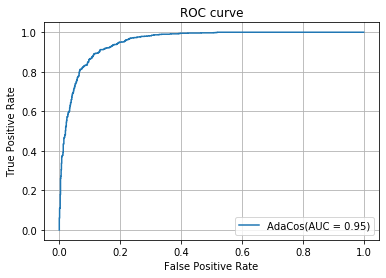

10 /10
Adacos training...


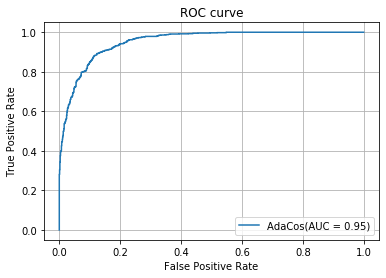

[0.9461229999999999, 0.929549, 0.951535, 0.8987144999999999, 0.892707, 0.896829, 0.9222784999999999, 0.9456009999999999, 0.9527025000000001, 0.9523605]


In [0]:
DATA = data(8000)
result = []

for i in range(10):
    print(i+1,"/10")
    x_train_normal, x_ref, y_ref, x_test_normal, x_test_anomaly = DATA.get_fashion_data()

    normal_label = np.zeros((len(x_train_normal), y_ref.shape[1]))
    normal_label[:,6] = 1

    #AdaCos
    model = train_adacos(np.vstack((x_train_normal, x_ref)), np.vstack((normal_label, y_ref)), y_ref.shape[1])
    # 異常スコアの算出（異常が高いほど、スコアが高くなるように符号反転）
    Z1_arc = -get_score_arc(model, x_train_normal, x_test_normal)
    Z2_arc = -get_score_arc(model, x_train_normal, x_test_anomaly)

    #auc
    result.append(auc(Z1_arc, Z2_arc))

print(result)

#Experiment(cifar-10)

1 /10
170500096/170498071 [==============================] - 4s 0us/step
Adacos training...


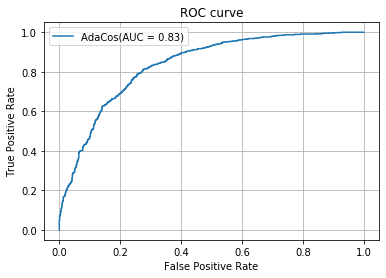

2 /10
Adacos training...


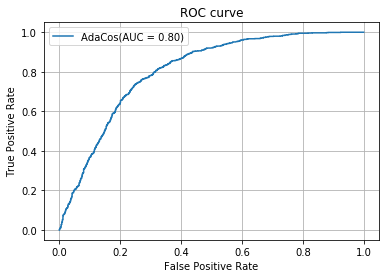

3 /10
Adacos training...


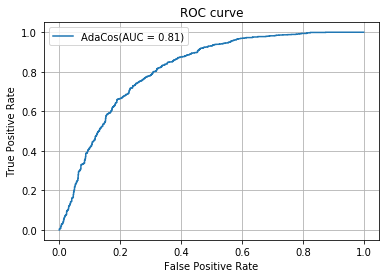

4 /10
Adacos training...


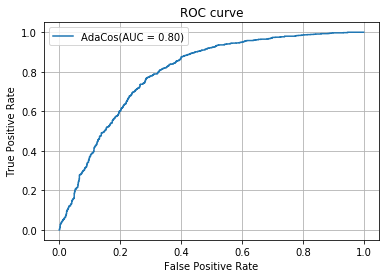

5 /10
Adacos training...


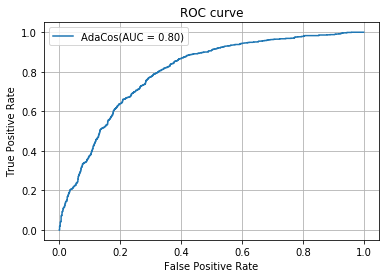

6 /10
Adacos training...


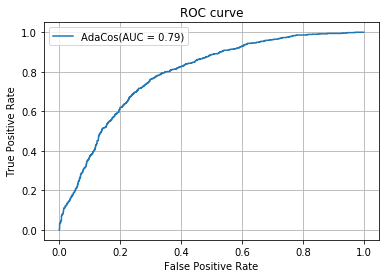

7 /10
Adacos training...


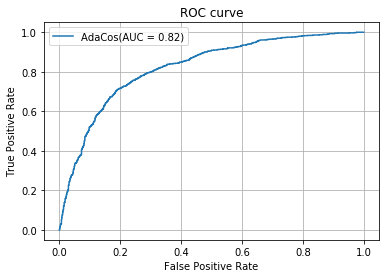

8 /10
Adacos training...


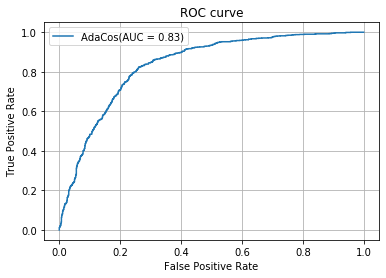

9 /10
Adacos training...


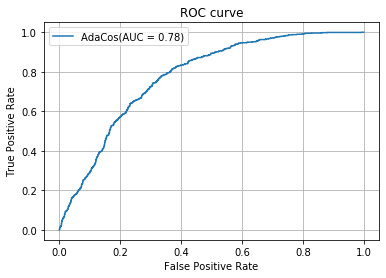

10 /10
Adacos training...


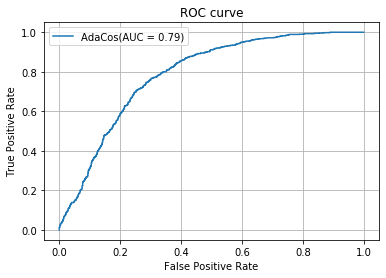

[0.8346085, 0.8047545, 0.8137224999999999, 0.7972685, 0.7997379999999998, 0.787372, 0.8217844999999999, 0.8345715, 0.7761755, 0.786005]


In [0]:
DATA = data(8000)
result = []

for i in range(10):
    print(i+1,"/10")
    x_train_normal, x_ref, y_ref, x_test_normal, x_test_anomaly = DATA.get_cifar_data()

    normal_label = np.zeros((len(x_train_normal), y_ref.shape[1]))
    normal_label[:,3] = 1

    # Adacos
    model = train_adacos(np.vstack((x_train_normal, x_ref)), np.vstack((normal_label, y_ref)), y_ref.shape[1])
    # 異常スコアの算出（異常が高いほど、スコアが高くなるように符号反転）
    Z1_arc = -get_score_arc(model, x_train_normal, x_test_normal)
    Z2_arc = -get_score_arc(model, x_train_normal, x_test_anomaly)

    #auc
    result.append(auc(Z1_arc, Z2_arc))

print(result)

# graph

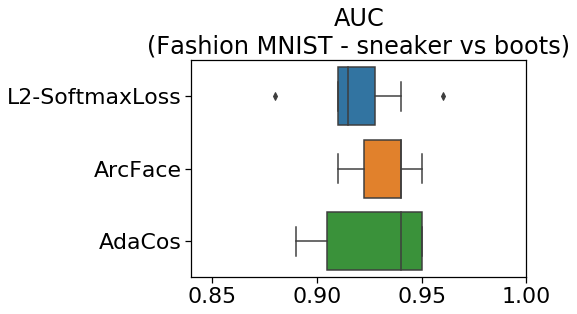

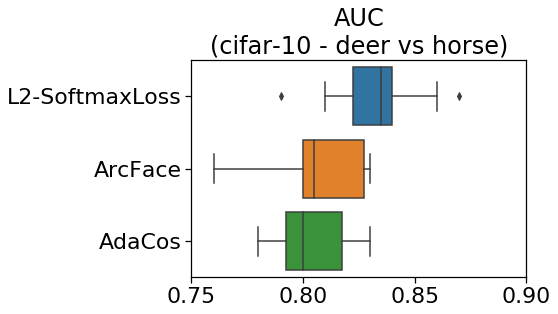

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

x = [[0.92, 0.94, 0.91, 0.96, 0.91, 0.91, 0.92, 0.93, 0.91, 0.88],
     [0.93, 0.94, 0.94, 0.92, 0.94, 0.95, 0.94, 0.91, 0.95, 0.92],
     [0.95, 0.93, 0.95, 0.90, 0.89, 0.90, 0.92, 0.95, 0.95, 0.95]]

sns.set_context("notebook",font_scale=2)
sns.boxplot(x=[x[0],x[1],x[2]], y=["L2-SoftmaxLoss","ArcFace","AdaCos"])
plt.title("AUC\n(Fashion MNIST - sneaker vs boots)")
plt.xlim(0.84,1)
plt.show()

x = [[0.83, 0.84, 0.86, 0.81, 0.84, 0.82, 0.84, 0.87, 0.79, 0.83],
     [0.77, 0.8, 0.83, 0.83, 0.8, 0.82, 0.83, 0.81, 0.76, 0.8],
     [0.83, 0.80, 0.81, 0.80, 0.80, 0.79, 0.82, 0.83, 0.78, 0.79]]

sns.set_context("notebook",font_scale=2)
sns.boxplot(x=[x[0],x[1],x[2]], y=["L2-SoftmaxLoss","ArcFace","AdaCos"])
plt.title("AUC\n(cifar-10 - deer vs horse)")
plt.xlim(0.75,0.9)
plt.show()